In [657]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
import folium.plugins
from folium.plugins import HeatMap

In [524]:
plt.rcParams['figure.figsize'] = [10, 5]

In [579]:
j_faults = pd.read_csv('data/J1939Faults.csv').reset_index(drop = True)
onboard_data = pd.read_csv('data/VehicleDiagnosticOnboardData.csv').reset_index(drop=True)
fault_codes = pd.read_csv('data/Service_Fault_Codes_1_0_0_167.csv').reset_index(drop=True)
vehicle = pd.read_csv('data/Vehicle_Make.csv').reset_index(drop=True)

C:\Users\cmerr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  MemoryError) as e:


Turn onboard data into a dataframe where each fault instance has one row. It is grouped on the FaultId which maps 1-to-1 on the RecordID.

In [580]:
#j_faults[j_faults[]]

In [581]:
ob_data = onboard_data.pivot(index='FaultId', columns='Name',values = 'Value').rename_axis(None)
pd.set_option('display.max_columns', None)
ob_data.reset_index(inplace=True)
ob_data = ob_data.rename(columns = {'index':'FaultId'})

Merge the on_data with the J1939 dataframe using the RecordID and FaultID.

In [582]:
ob_faults = pd.merge(j_faults, ob_data, how='left', left_on='RecordID', right_on='FaultId')

Sums up the number of null values in a row

In [583]:
ob_faults['null_count'] = ob_faults.isnull().sum(axis=1)

Corrects the datatype in certain rows

In [584]:
problem_cols = ['AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlActive',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IgnStatus',
 'IntakeManifoldTemperature',
 'LampStatus',
 'ParkingBrake',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure']
for x in problem_cols:
    try:
        ob_faults[x] = ob_faults[x].str.replace(',','').astype(float)
    except ValueError:
        ob_faults[x] = ob_faults[x]
ob_faults['EventTimeStamp'] =  pd.to_datetime(ob_faults['EventTimeStamp'], format='%Y%m%d %H:%M:%S.%f')

Adds a check for instances where the location is in the values Big G instructed us to ignore.

In [585]:
ob_faults['repair_center'] = False
ob_faults.loc[(ob_faults['Longitude'].astype('str').str.contains(r'-86.4\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'36.0\d+')), 'repair_center'] = True
ob_faults.loc[(ob_faults['Longitude'].astype('str').str.contains(r'-86.44\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'35.58\d+')), 'repair_center'] = True
ob_faults.loc[(ob_faults['Longitude'].astype('str').str.contains(r'-83.17\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'36.19\d+')), 'repair_center'] = True
ob_faults = ob_faults[ob_faults['repair_center']==False]

Removes instances where the EquipmentID is more than 5 characters (instructions from Big G)

In [586]:
ob_faults['EquipmentID_count'] = ob_faults['EquipmentID'].astype(str).str.len() 
ob_faults = ob_faults[ob_faults['EquipmentID_count'] < 6]

In [587]:
ob_faults['EquipmentID'] = ob_faults['EquipmentID'].astype(str)

In [588]:
combined_df = ob_faults.drop(columns=['actionDescription','EquipmentID_count','repair_center','faultValue'])

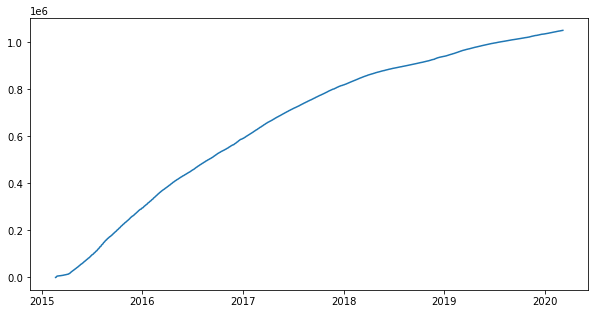

In [589]:
five_years = combined_df[(combined_df['EventTimeStamp'] > '2012-01-01') & (combined_df['EventTimeStamp'] < '2022-01-01')]
time_sorted = five_years[['EventTimeStamp']]
time_sorted = time_sorted.sort_values(by=['EventTimeStamp']).reset_index(drop=True)
y = time_sorted.index.tolist()
x = time_sorted['EventTimeStamp']
plt.plot(x,y)
plt.show()

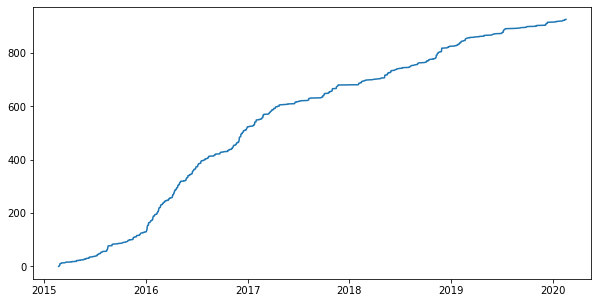

In [590]:
five_years = combined_df[(combined_df['EventTimeStamp'] > '2012-01-01') & (combined_df['EventTimeStamp'] < '2022-01-01')]
derate_five = five_years[five_years['spn']==5246]
time_sorted = derate_five[['EventTimeStamp']]
time_sorted = time_sorted.sort_values(by=['EventTimeStamp']).reset_index(drop=True)
y = time_sorted.index.tolist()
x = time_sorted['EventTimeStamp']
plt.plot(x,y)
plt.show()

In [591]:
combined_df['Month'] = pd.DatetimeIndex(combined_df['EventTimeStamp']).month

array([[<AxesSubplot:title={'center':'Month'}>]], dtype=object)

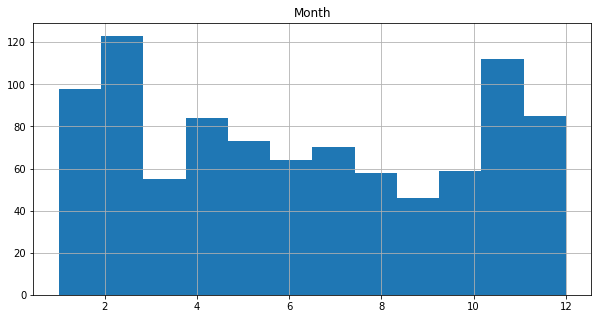

In [592]:
five_years = combined_df[(combined_df['EventTimeStamp'] > '2012-01-01') & (combined_df['EventTimeStamp'] < '2022-01-01')]

derate_five = five_years[five_years['spn']==5246]

time_sorted = derate_five[['Month']]
monthprint = derate_five.groupby('Month').count()
derate_five.hist(column='Month', bins=12)

array([[<AxesSubplot:title={'center':'dayofyear'}>]], dtype=object)

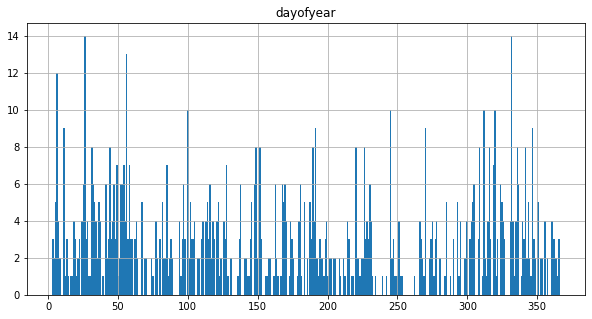

In [593]:
combined_df['dayofyear'] = combined_df['EventTimeStamp'].dt.dayofyear

five_years = combined_df[(combined_df['EventTimeStamp'] > '2012-01-01') & (combined_df['EventTimeStamp'] < '2022-01-01')]

derate_five = five_years[five_years['spn']==5246]

time_sorted = derate_five[['dayofyear']]
monthprint = derate_five.groupby('dayofyear').count()
derate_five.hist(column='dayofyear', bins=365)

In [594]:
five_years = combined_df[(combined_df['EventTimeStamp'] > '2012-01-01') & (combined_df['EventTimeStamp'] < '2022-01-01')]

derate_five = five_years[five_years['spn']==5246]

derate_five.groupby("Month").count()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,dayofyear
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,98,98,98,0,74,73,73,73,98,98,98,98,98,98,98,98,98,98,98,29,52,22,22,47,52,52,52,51,52,42,52,52,52,34,52,52,98,12,0,50,30,10,51,98,98
2,123,123,123,0,106,100,100,100,123,123,123,123,123,123,123,123,123,123,123,52,63,51,53,63,63,61,63,60,63,55,62,64,61,28,68,63,123,28,0,60,12,31,61,123,123
3,55,55,55,0,53,52,52,52,55,55,55,55,55,55,55,55,55,55,55,21,26,24,24,26,26,26,26,25,26,24,23,25,26,5,29,26,55,11,0,26,2,11,26,55,55
4,84,84,84,0,58,58,58,58,84,84,84,84,84,84,84,84,84,84,84,28,42,19,21,41,42,41,42,39,42,31,40,38,40,24,44,42,84,7,0,40,22,9,40,84,84
5,73,73,73,0,51,50,50,50,73,73,73,73,73,73,73,73,73,73,73,26,38,22,23,34,38,37,38,37,38,33,38,38,37,24,40,38,73,20,0,37,16,20,37,73,73
6,64,64,64,0,54,54,54,54,64,64,64,64,64,64,64,64,64,64,64,25,31,23,23,30,31,31,31,31,31,28,28,31,31,14,34,31,64,11,0,31,10,9,31,64,64
7,70,70,70,0,67,62,62,62,70,70,70,70,70,70,70,70,70,70,70,27,31,23,24,31,31,30,31,30,31,26,30,30,30,19,39,31,70,13,0,30,7,17,30,70,70
8,58,58,58,0,43,42,50,50,58,58,58,58,58,58,58,58,58,58,58,17,20,16,16,19,20,20,20,20,20,18,18,21,20,11,31,20,58,13,0,20,4,13,20,58,58
9,46,46,46,0,46,41,41,41,46,46,46,46,46,46,46,46,46,46,46,21,25,23,23,23,25,25,25,24,25,25,20,25,25,12,25,25,46,17,0,24,2,13,25,46,46


In [595]:
combined_df[(combined_df['EventTimeStamp'] < '2018-01-01') & (combined_df['EventTimeStamp'] > '2016-01-01')]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,Month,dayofyear
325794,330851,6613147,2016-01-01 00:06:01,Abnormal Update Rate Tire Location,unknown,unknown,unknown,unknown,49,929,9,False,126,1610,105415630,35.653287,-80.459120,2016-01-01 00:05:56.000,330851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,25,1,1
325795,330852,6613188,2016-01-01 00:21:57,Abnormal Update Rate Tire Location,unknown,unknown,unknown,unknown,49,929,9,False,126,1605,105415080,30.679166,-81.458425,2016-01-01 00:21:52.000,330852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,25,1,1
325796,330853,6613191,2016-01-01 00:22:29,Abnormal Update Rate Tire Location,unknown,unknown,unknown,unknown,49,929,9,True,126,1605,105415080,30.679074,-81.459212,2016-01-01 00:23:04.000,330853,0.0,14.7175,False,66.48672,341299.4,181.4,14.0,22.62,202.0437,601.125,6737.50,NaN,48431.718981,0.647223,32.0,True,131.0,1279.0,False,NaN,4.407852,NaN,100.0,0.58,5,1,1
325798,330855,6613252,2016-01-01 00:43:16,High (Severity Medium) Aftertreatment 1 Partic...,04993120*00040893*082113134117*07700053*I0*BBZ*,79476012,6X1u10D1500000000,CMMNS,0,3251,16,False,1,1454,105358372,30.251388,-82.517731,2016-01-01 00:43:11.000,330855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25,1,1
325799,330856,6613277,2016-01-01 00:52:47,Abnormal Update Rate Tire Location,unknown,unknown,unknown,unknown,49,929,9,False,126,1605,105415080,30.679074,-81.459212,2016-01-01 00:52:43.000,330856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,25,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913130,938942,35909083,2017-12-31 20:24:27,NaN,5569976 *E245.e002*,K1243379,FAOM-xx810S-EC3,EATON,3,639,12,False,22,2106,105411891,33.541666,-84.575601,2017-12-31 20:24:22.000,938942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,26,12,365
913132,938944,35911041,2017-12-31 21:55:50,Low (Severity Medium) Engine Coolant Level,04358814*06163860*061516161145*09401661*G1*BDR*,79951760,6X1u13D1500000000,CMMNS,0,111,18,True,2,2011,105437762,36.744212,-80.772870,2017-12-31 21:58:27.000,938944,0.0,13.4850,False,66.48672,101241.7,35.6,23.0,45.82,40.6625,800.750,2016.95,24.0,14013.006498,1.915253,NaN,True,23.0,2047.0,True,NaN,0.000000,NaN,100.0,0.87,5,12,365
913133,938945,35911078,2017-12-31 22:00:48,Low (Severity Medium) Engine Coolant Level,04358814*06163860*061516161145*09401661*G1*BDR*,79951760,6X1u13D1500000000,CMMNS,0,111,18,False,2,2011,105437762,36.744212,-80.772870,2017-12-31 22:00:43.000,938945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25,12,365
913248,939060,35935793,2017-12-31 12:38:04,Abnormal Update Rate Tire Location,unknown,unknown,unknown,unknown,49,929,9,True,126,1609,105415391,27.964027,-82.407314,2018-01-01 00:07:31.000,939060,5.6,14.7175,False,64.62260,604658.3,183.2,0.0,36.54,193.3813,963.750,13233.30,39.2,86020.231916,0.000000,NaN,True,136.4,1279.0,False,NaN,12.670150,NaN,100.0,1.16,5,12,365


In [596]:
combined_df[combined_df['EquipmentID']==1393]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,Month,dayofyear


In [597]:
combined_df[combined_df['activeTransitionCount']<1]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,Month,dayofyear
4334,4335,1049783,2015-02-24 14:38:29,NaN,04993120*00017231*040213150018*07700044*I0*BBZ*,79461374,6X1u10D1500000000,CMMNS,0,5319,31,False,0,1372,105351194,38.349120,-85.708981,2015-02-24 14:38:25.000,4335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,26,2,55
8759,8760,1326983,2015-03-12 16:41:29,Incorrect Data Engine Intake Manifold #1 Pressure,04993120*00000552*042114185815*07700062*I0*BBZ*,79452480,6X1u10D1500000000,CMMNS,0,102,2,False,0,1368,105338729,40.841435,-74.021898,2015-03-12 16:41:24.000,8760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25,3,71
9362,9363,1389314,2015-03-17 05:13:57,NaN,unknown,unknown,unknown,unknown,49,51923,0,True,0,1355,105338815,36.867685,-86.885000,2015-03-17 05:14:50.000,9363,0.0,14.3550,False,66.48672,459603.6,77.0,38.0,40.60,71.20625,646.25,8960.05,94.8,69846.826377,2.43039,NaN,True,57.2,2.0,True,NaN,0.0,3276.75,NaN,1.74,6,3,76
9857,9858,1432365,2015-03-19 06:17:56,NaN,unknown,unknown,unknown,unknown,49,51923,0,True,0,1340,105399896,32.951574,-96.915879,2015-03-19 06:18:47.000,9858,0.0,14.4275,False,64.62260,491563.4,192.2,10.0,17.98,205.53130,650.50,9461.95,47.2,74827.129987,0.48872,NaN,False,80.6,2.0,False,NaN,0.0,3276.75,NaN,NaN,7,3,78
9858,9859,1432373,2015-03-19 06:19:31,NaN,unknown,unknown,unknown,unknown,49,51923,0,False,0,1340,105399896,32.951666,-96.916157,2015-03-19 06:19:27.000,9859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,26,3,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185606,1246730,122978490,2020-02-29 05:45:00,Not Reporting Data Brake Light Switch 1,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,5W24154923,EC80ESP,BNDWS,11,1045,7,True,0,1826,105416377,38.762453,-78.628564,2020-02-29 05:45:36.000,1246730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9264.10,NaN,61392.660283,NaN,NaN,True,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,22,2,60
1186652,1247776,123554597,2020-03-04 13:30:58,Not Reporting Data Brake Light Switch 1,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,5W24154923,EC80ESP,BNDWS,11,1045,7,True,0,1826,105416377,36.660324,-86.555740,2020-03-04 13:31:35.000,1247776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,24,3,64
1186750,1247874,123606252,2020-03-04 19:14:22,Not Reporting Data Brake Light Switch 1,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,5W24154923,EC80ESP,BNDWS,11,1045,7,False,0,1826,105416377,35.978564,-85.016018,2020-03-04 19:14:18.000,1247874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,25,3,64
1186986,1248110,123728935,2020-03-05 13:19:08,Not Reporting Data Brake Light Switch 1,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,5W24154923,EC80ESP,BNDWS,11,1045,7,True,0,1826,105416377,36.759074,-86.170787,2020-03-05 13:19:43.000,1248110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,24,3,65


In [598]:
derate_df = combined_df[combined_df["spn"]==5246]
derate_df['event_year'] = pd.DatetimeIndex(derate_df['EventTimeStamp']).year

<ipython-input-598-ceb9908d09f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derate_df['event_year'] = pd.DatetimeIndex(derate_df['EventTimeStamp']).year


In [599]:
nash_map = folium.Map(location = [36.1627, -86.7816], zoom_start = 5)

In [600]:
derate_2016=folium.FeatureGroup(name='Derates 2016', show=False)
derate_2017=folium.FeatureGroup(name='Derates 2017', show=False)
derate_2018=folium.FeatureGroup(name='Derates 2018', show=False)
derate_2019=folium.FeatureGroup(name='Derates 2019', show=False)
derate_2020=folium.FeatureGroup(name='Derates 2020', show=False)
derate_2021=folium.FeatureGroup(name='Derates 2021', show=False)
other_year=folium.FeatureGroup(name='Out of Range', show=False)

nash_map.add_child(derate_2016)
nash_map.add_child(derate_2017)
nash_map.add_child(derate_2018)
nash_map.add_child(derate_2019)
nash_map.add_child(derate_2020)
nash_map.add_child(derate_2021)
nash_map.add_child(other_year)
folium.LayerControl().add_to(nash_map)

In [660]:
for lat_to, lng_to, event_date, event_yr, truck_num in zip(derate_df['Latitude'], derate_df['Longitude'], 
                                                           derate_df['EventTimeStamp'], derate_df['event_year'], 
                                                           derate_df['EquipmentID']):
    derate_layer = other_year
    if event_yr == 2016:
        derate_layer = derate_2016
    elif event_yr == 2017:
        derate_layer = derate_2017
    elif event_yr == 2018:
        derate_layer = derate_2018
    elif event_yr == 2019:
        derate_layer = derate_2019
    elif event_yr == 2020:
        derate_layer = derate_2020
    elif event_yr == 2021:
        derate_layer = derate_2021
    folium.Marker([lat_to,lng_to],
                  tooltip=(str(event_date) + ' ' + str(truck_num))
    ).add_to(derate_layer)

In [666]:
#data = (
#    np.random.normal(size=(100, 3)) *
#    np.array([[1, 1, 1]]) +
#    np.array([[48, 5, 1]])
#).tolist()
#m = folium.Map([48, 5], tiles='stamentoner', zoom_start=6)

#HeatMap(data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
#folium.LayerControl().add_to(m)
nash_heat_map = folium.Map(location = [36.1627, -86.7816], zoom_start = 5)

lat_long = ['Latitude','Longitude']
derate_location = derate_df[lat_long]
HeatMap(derate_location).add_to(folium.FeatureGroup(name='Heat Map').add_to(nash_heat_map))
folium.LayerControl().add_to(nash_heat_map)


In [667]:
nash_heat_map

In [603]:
derate_df.groupby('EquipmentID').count()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,Month,dayofyear,event_year
EquipmentID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1329,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,2,2,2,2
1339,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,1
1366,8,8,8,0,8,8,8,8,8,8,8,8,8,8,8,8,8,8,4,4,4,4,4,4,4,4,4,4,4,0,4,4,0,4,4,8,4,0,4,3,0,4,8,8,8,8
1373,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,2,0,0,1,0,0,1,2,2,2,2
1375,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,2,0,0,1,0,0,1,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1
302,6,6,6,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,3,0,3,0,3,3,6,6,6,6
304,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,0,1,0,1,1,2,2,2,2


In [604]:
len(pd.unique(derate_df['EquipmentID']))

191

In [605]:
derate_df[derate_df['EquipmentID']==305]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,Month,dayofyear,event_year


In [606]:
derate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932 entries, 2089 to 1182657
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RecordID                   932 non-null    int64         
 1   ESS_Id                     932 non-null    int64         
 2   EventTimeStamp             932 non-null    datetime64[ns]
 3   eventDescription           0 non-null      object        
 4   ecuSoftwareVersion         787 non-null    object        
 5   ecuSerialNumber            761 non-null    object        
 6   ecuModel                   769 non-null    object        
 7   ecuMake                    769 non-null    object        
 8   ecuSource                  932 non-null    int64         
 9   spn                        932 non-null    int64         
 10  fmi                        932 non-null    int64         
 11  active                     932 non-null    bool          
 12  a

In [607]:
derate_df.sort_values(by=["EquipmentID","EventTimeStamp"], inplace=True)
combined_df.sort_values(by=["EquipmentID","EventTimeStamp"], inplace=True)

<ipython-input-607-3b3578beb128>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derate_df.sort_values(by=["EquipmentID","EventTimeStamp"], inplace=True)


In [608]:
combined_df

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,Month,dayofyear
41577,42689,2241022,2015-05-04 15:38:35,NaN,unknown,unknown,unknown,unknown,49,50353,0,True,2,1327,105383198,35.988750,-83.579583,2015-05-04 15:39:11.000,42689,100.0,14.2825,False,62.13712,517711.80,183.2,90.0,33.64,216.6125,1359.125,10323.10,NaN,78862.886425,16.854230,NaN,True,113.0,2.0,False,NaN,64.680850,3276.75,NaN,26.39,7,5,124
41580,42692,2241075,2015-05-04 15:42:02,NaN,unknown,unknown,unknown,unknown,49,50353,0,False,2,1327,105383198,35.983796,-83.631944,2015-05-04 15:41:58.000,42692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,26,5,124
44555,45667,2296851,2015-05-07 06:52:14,Condition Exists Cruise Control Enable Switch,unknown,unknown,unknown,unknown,49,596,31,True,126,1327,105383198,40.197500,-74.661435,2015-05-07 06:52:50.000,45667,0.0,14.7900,False,64.62260,518554.70,185.0,14.0,25.52,165.8750,648.375,10338.70,NaN,78990.877785,0.766101,NaN,True,102.2,255.0,False,NaN,0.000000,3276.75,NaN,1.74,6,5,127
44833,45945,2302281,2015-05-07 10:25:59,Condition Exists Cruise Control Enable Switch,unknown,unknown,unknown,unknown,49,596,31,False,126,1327,105383198,40.198148,-74.660879,2015-05-07 10:25:55.000,45945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,25,5,127
56739,58809,2507532,2015-05-19 12:02:55,Abnormal Update Rate Aftertreatment 1 Intake NOx,04993120*00001782*082113134117*07700053*I0*BBZ*,79419774,6X1u10D1500000000,CMMNS,0,3216,9,True,1,1327,105383198,35.491250,-86.458842,2015-05-19 12:03:32.000,58809,11.6,14.3550,False,64.62260,520309.60,185.0,0.0,31.90,203.8438,1083.125,10374.80,NaN,79274.466482,0.000000,NaN,True,109.4,17407.0,False,NaN,27.563640,3276.75,NaN,2.90,6,5,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494,4495,1052146,2015-02-24 16:24:05,Low (Severity Medium) Catalyst Tank Level,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,1761,18,False,11,R1762,105442816,39.551851,-86.045925,2015-02-24 16:24:00.000,4495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25,2,55
6438,6439,1089561,2015-02-26 13:12:11,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,5848,9,True,1,R1762,105442816,39.952870,-81.936990,2015-02-26 13:12:48.000,6439,0.0,14.2100,False,66.48672,80838.70,134.6,11.0,38.86,148.7188,595.750,1547.55,22.4,11527.675833,0.660432,32.0,True,84.2,17407.0,False,NaN,2.058292,3276.75,0.0,0.29,4,2,57
6446,6447,1090499,2015-02-26 13:50:59,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,5848,9,False,1,R1762,105442816,39.953379,-81.937407,2015-02-26 13:50:54.000,6447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,26,2,57
4952,4953,1059704,2015-02-25 06:08:43,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,unknown,unknown,unknown,11,639,2,True,127,R1764,105442911,36.001296,-86.501435,2015-02-25 06:10:53.000,4953,21.6,14.4275,False,66.48672,83681.85,154.4,12.0,40.60,160.9250,945.375,1562.75,93.6,11847.191930,1.598246,32.0,True,93.2,1279.0,False,NaN,4.378725,3276.75,0.0,1.74,3,2,56


In [609]:
combined_df[~combined_df['DistanceLtd'].isnull()]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,Month,dayofyear
41577,42689,2241022,2015-05-04 15:38:35,NaN,unknown,unknown,unknown,unknown,49,50353,0,True,2,1327,105383198,35.988750,-83.579583,2015-05-04 15:39:11.000,42689,100.0,14.2825,False,62.13712,517711.80,183.2,90.0,33.64,216.61250,1359.125,10323.10,NaN,78862.886425,16.854230,NaN,True,113.0,2.0,False,NaN,64.680850,3276.75,NaN,26.39,7,5,124
44555,45667,2296851,2015-05-07 06:52:14,Condition Exists Cruise Control Enable Switch,unknown,unknown,unknown,unknown,49,596,31,True,126,1327,105383198,40.197500,-74.661435,2015-05-07 06:52:50.000,45667,0.0,14.7900,False,64.62260,518554.70,185.0,14.0,25.52,165.87500,648.375,10338.70,NaN,78990.877785,0.766101,NaN,True,102.2,255.0,False,NaN,0.000000,3276.75,NaN,1.74,6,5,127
56739,58809,2507532,2015-05-19 12:02:55,Abnormal Update Rate Aftertreatment 1 Intake NOx,04993120*00001782*082113134117*07700053*I0*BBZ*,79419774,6X1u10D1500000000,CMMNS,0,3216,9,True,1,1327,105383198,35.491250,-86.458842,2015-05-19 12:03:32.000,58809,11.6,14.3550,False,64.62260,520309.60,185.0,0.0,31.90,203.84380,1083.125,10374.80,NaN,79274.466482,0.000000,NaN,True,109.4,17407.0,False,NaN,27.563640,3276.75,NaN,2.90,6,5,139
63869,65939,2611189,2015-05-26 08:44:10,Abnormal Update Rate Aftertreatment 1 Intake NOx,04993120*00001782*082113134117*07700053*I0*BBZ*,79419774,6X1u10D1500000000,CMMNS,0,3216,9,True,1,1327,105383198,35.523703,-86.440787,2015-05-26 08:52:22.000,65939,48.8,14.3550,False,64.62260,520314.60,161.6,45.0,38.86,154.51250,1170.000,10375.15,NaN,79275.391085,4.530565,NaN,True,100.4,17407.0,False,NaN,28.796670,3276.75,NaN,6.67,6,5,146
6526,6527,1097093,2015-02-26 20:14:29,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,111,17,True,2,1328,105369308,35.171018,-89.869722,2015-02-26 20:15:05.000,6527,20.0,14.7900,False,59.65163,495105.00,59.0,33.0,45.82,51.74375,860.375,9783.05,94.0,75030.410381,2.615312,NaN,True,39.2,1023.0,True,NaN,0.000000,3276.75,NaN,2.61,5,2,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157136,1214360,109664481,2019-11-12 00:24:39,Incorrect Data J1939 Network #1 Primary Vehicl...,BB41103* BB41104*,S211411637,EC60-adv,BNDWS,11,639,2,True,127,310,105455566,35.271666,-86.397361,2019-11-12 00:25:16.000,1214360,32.4,14.3550,False,0.00000,327738.30,185.0,16.0,40.02,198.27500,1212.625,9940.35,65.2,44386.056091,2.166218,NaN,True,102.2,1279.0,False,NaN,4.466105,NaN,100.0,2.61,5,11,316
4245,4246,1048627,2015-02-24 13:45:06,Low (Severity Low) Catalyst Tank Level,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,1761,17,True,43,R1762,105442816,41.254166,-85.088888,2015-02-24 13:45:41.000,4246,0.0,14.0650,True,66.48672,79796.12,185.0,83.0,42.34,222.68750,1333.250,1527.45,38.0,11368.512172,14.727640,32.0,True,82.4,1023.0,False,NaN,65.962430,3276.75,47.2,16.82,3,2,55
4427,4428,1051023,2015-02-24 15:31:17,Low (Severity Medium) Catalyst Tank Level,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,1761,18,True,11,R1762,105442816,39.944444,-86.016990,2015-02-24 15:31:52.000,4428,0.0,14.1375,True,66.48672,79913.24,179.6,53.0,42.34,222.68750,1352.875,1529.25,22.0,11390.042194,9.166799,32.0,True,82.4,1023.0,False,NaN,66.836240,3276.75,67.2,8.99,3,2,55
6438,6439,1089561,2015-02-26 13:12:11,NaN,05

In [620]:
keeplist = ['EquipmentID','EventTimeStamp']
combined_df[keeplist]

,EquipmentID,EventTimeStamp
41577,1327,2015-05-04 15:38:35
41580,1327,2015-05-04 15:42:02
44555,1327,2015-05-07 06:52:14
44833,1327,2015-05-07 10:25:59
56739,1327,2015-05-19 12:02:55
...,...,...
4494,R1762,2015-02-24 16:24:05
6438,R1762,2015-02-26 13:12:11
6446,R1762,2015-02-26 13:50:59
4952,R1764,2015-02-25 06:08:43


In [610]:
combined_df.loc[combined_df['']]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count,Month,dayofyear,event_year
5713,5714,1070646,2015-02-25 13:53:08,NaN,unknown,unknown,unknown,unknown,0,5246,0,True,1,1329,105400037,39.399583,-82.974768,2015-02-25 13:56:31.000,5714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527.0,NaN,NaN,NaN,NaN,NaN,NaN,25,2,56,2015
5809,5810,1071907,2015-02-25 14:47:00,NaN,unknown,unknown,unknown,unknown,0,5246,0,False,1,1329,105400037,39.399629,-82.974814,2015-02-25 14:46:56.000,5810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407.0,NaN,NaN,NaN,NaN,NaN,NaN,26,2,56,2015
83425,85811,2928718,2015-06-12 15:35:22,NaN,unknown,unknown,unknown,unknown,0,5246,0,True,1,1339,105366200,37.035324,-86.336018,2015-06-12 15:35:58.000,85811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527.0,NaN,NaN,NaN,NaN,NaN,NaN,25,6,163,2015
82772,85158,2918010,2015-06-12 06:13:27,NaN,unknown,unknown,unknown,unknown,0,5246,0,True,1,1366,105340123,35.146018,-86.578888,2015-06-12 07:17:28.000,85158,0.0,14.3550,False,66.48672,507636.9,186.8,16.0,21.46,192.9875,649.625,10450.0,NaN,77645.053266,0.792519,NaN,True,134.6,22527.0,True,NaN,0.0,3276.75,NaN,0.58,7,6,163,2015
82773,85159,2918021,2015-06-12 07:18:25,NaN,unknown,unknown,unknown,unknown,0,5246,0,False,1,1366,105340123,35.146064,-86.578935,2015-06-12 07:18:21.000,85159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407.0,NaN,NaN,NaN,NaN,NaN,NaN,26,6,163,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039516,1080396,68549599,2018-11-16 10:25:51,NaN,unknown,unknown,unknown,unknown,49,5246,19,True,40,305,105362919,38.192546,-85.707685,2018-11-16 10:26:27.000,1080396,0.0,14.5000,False,0.00000,279374.4,167.0,10.0,43.50,171.2750,650.500,10799.8,38.0,44671.361907,0.528346,64.4,True,123.8,255.0,True,NaN,0.0,NaN,0.0,0.29,5,11,320,2018
1039597,1080477,68574413,2018-11-16 13:12:46,NaN,unknown,unknown,unknown,unknown,49,5246,19,False,40,305,105362919,38.192453,-85.707685,2018-11-16 13:12:41.000,1080477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,26,11,320,2018
1041171,1082051,68976239,2018-11-20 14:37:43,NaN,unknown,unknown,unknown,unknown,49,5246,19,True,42,305,105362919,38.192268,-85.707453,2018-11-20 14:38:19.000,1082051,0.0,14.5725,False,0.00000,279409.7,156.2,13.0,46.98,161.3750,650.750,10804.7,26.8,44678.890811,1.426534,69.8,True,102.2,255.0,True,NaN,0.0,NaN,0.0,0.87,5,11,324,2018
1041537,1083374,69085173,2018-11-21 13:48:29,NaN,unknown,unknown,unknown,unknown,49,5246,19,False,42,305,105362919,38.192546,-85.707685,2018-11-20 23:30:06.000,1083374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,26,11,325,2018


In [625]:
derate_df_null = derate_df[~derate_df['DistanceLtd'].isnull()]

In [629]:
format1 = "%Y-%m-%d %H:%M:%S"
format2 = "%Y-%m-%d"

derate_df_null['date_group'] = pd.to_datetime(derate_df_null['EventTimeStamp'], format=format1).dt.strftime(format2)

<ipython-input-629-150570916ac5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derate_df_null['date_group'] = pd.to_datetime(derate_df_null['EventTimeStamp'], format=format1).dt.strftime(format2)


In [651]:
derate_show = derate_df_null.groupby(by = ['EquipmentID','date_group']).mean()
#derate_df_null

In [650]:
#derate_index = derate_show[""]

Index(['2015-06-12', '2015-06-13', '2015-07-03', '2015-09-23', '2016-01-08',
       '2015-10-29', '2016-02-03', '2015-11-16', '2015-12-27', '2016-02-12',
       ...
       '2016-02-01', '2018-06-25', '2018-09-26', '2018-11-05', '2018-11-08',
       '2018-11-12', '2018-11-15', '2018-11-16', '2018-11-20', '2018-09-07'],
      dtype='object', name='date_group', length=350)

Text(0.5, 1.0, 'Distance at time of Derate')

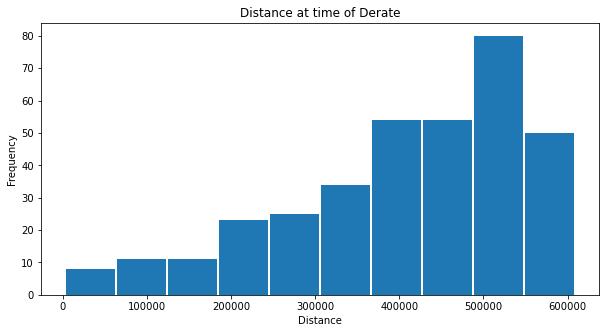

In [656]:
plt.hist(derate_show['DistanceLtd'], rwidth=0.95)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distance at time of Derate')

Text(0.5, 1.0, 'Distance at time of Derate')

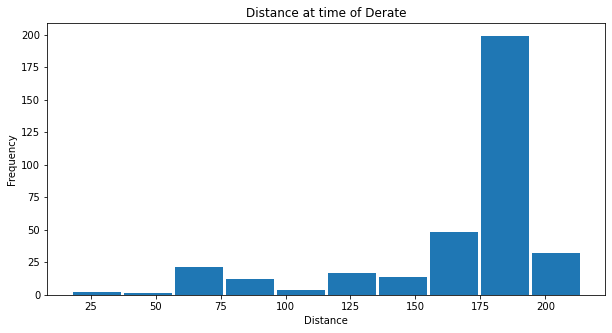

In [668]:
plt.hist(derate_show['EngineCoolantTemperature'], rwidth=0.95)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distance at time of Derate')